In [1]:
from TMSAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration
from TMSAnalysis.TMSUtilities.GetCuts import Cut
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import uproot, glob, time, copy
from datetime import datetime
import pandas as pd
import numpy as np

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 15


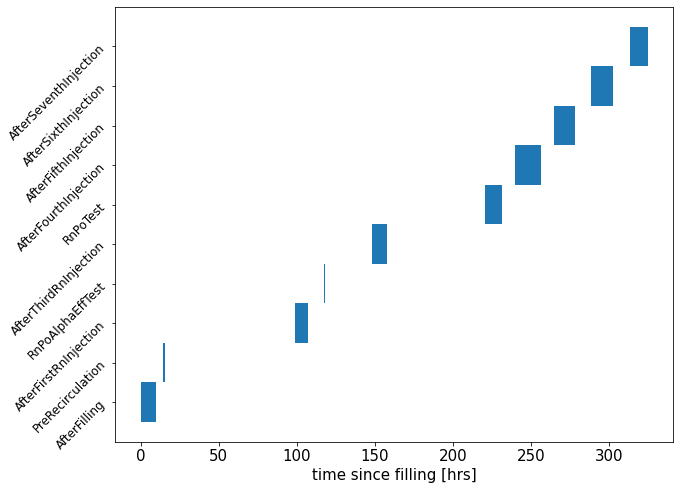

In [10]:
first = True
i=0
delta_x = []
width_x = []
path_to_reduced = '/p/lustre1/jacopod/30th/'
folder_list = glob.glob(path_to_reduced+'2020*/analysis_500ns/')
sorted_folder = sorted(folder_list)


for folder in folder_list:
    flist = sorted(glob.glob(folder + '*_reduced.h5'))
    fname = datetime.strptime(flist[0].split('/')[-1].split('_')[2], '%Y%m%d%H%M%S')
    lname = datetime.strptime(flist[-1].split('/')[-1].split('_')[2], '%Y%m%d%H%M%S')
    if first:
        start_run = fname
        first = False
    delta_x.append((fname-start_run).days*24+(fname-start_run).seconds/3600.0)
    width_x.append((lname-fname).days*24+(lname-fname).seconds/3600.0)
    
sorted_start = sorted(delta_x-np.min(delta_x))#,width_x
sorted_width = [x for _,x in sorted(zip(delta_x-np.min(delta_x),width_x))]
sorted_folder = [x for _,x in sorted(zip(delta_x-np.min(delta_x),(f_l.split('/')[-3].split('_')[-1] for f_l in folder_list)))]

width_y = 1
for i,e in enumerate(sorted_start):
    plt.broken_barh([(e,sorted_width[i])],(i*width_y,width_y))
    
plt.xlabel('time since filling [hrs]')
plt.yticks(np.arange(len(sorted_start)) + 0.5,sorted_folder,rotation=45,fontsize=12)
plt.show()

In [11]:
!ls $path_to_reduced

20200207_PreRecirculation    20200212_RecoverY17X19
20200210_AfterRecirculation  20200213_AfterRnInjection
20200211_AfterRecirculation  20200213_DuringRnInjection
20200212_RecirculationOff    analysis_2500ns


In [12]:
folder_list = ['20200207_PreRecirculation','20200211_AfterRecirculation',\
               '20200212_RecirculationOff', '20200212_RecoverY17X19']

In [13]:
def fit_function(x, A, beta, B, mu_first_peak, sigma_first_peak, C, mu_second_peak, sigma_second_peak):
    return (A * np.exp(-x/beta) +\
            B * np.exp(-1.0 * (x - mu_first_peak)**2 / (2 * sigma_first_peak**2)) +\
            C * np.exp(-1.0 * (x - mu_second_peak)**2 / (2 * sigma_second_peak**2)))

In [14]:
def get_chi2(expected, observed, sigma):
    return np.sum(np.square((expected - observed)/sigma))

here I loop through the main runs and plot the spectrum, fitting the peaks from the source the relative position between peaks and branching ratios are left floating in the fit

dataframe with 2086590 events loaded in 111.5s


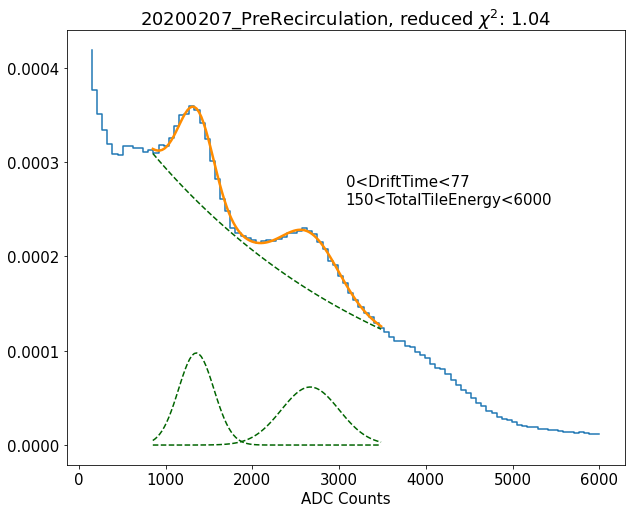

dataframe with 408751 events loaded in 48.2s


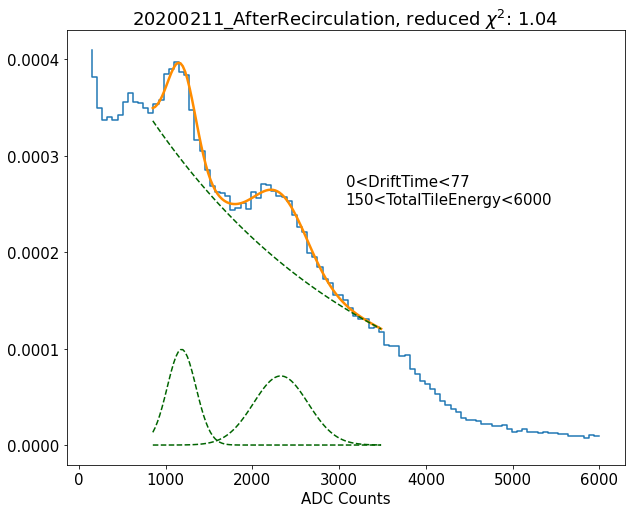

dataframe with 1026478 events loaded in 61.2s


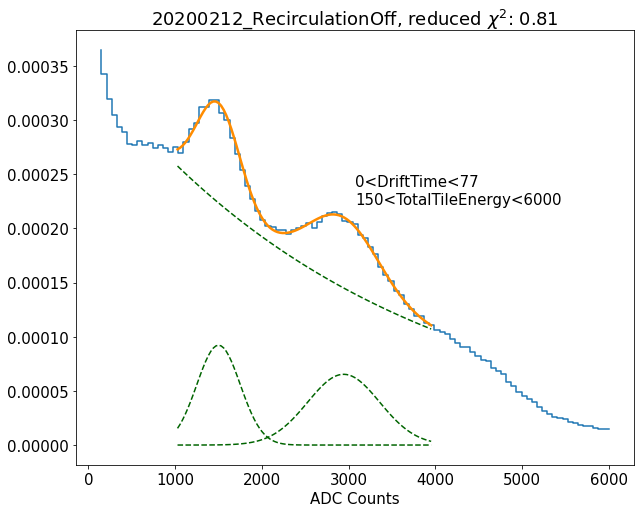

dataframe with 1518349 events loaded in 110.7s


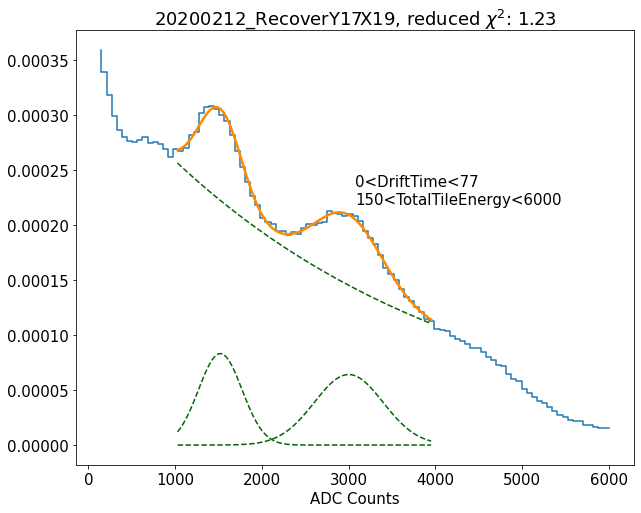

In [15]:
parameter_list = {'values':[], 'errors':[]}
cut_array = ['DriftTime>0', 'DriftTime<77',\
             'TotalTileEnergy>150', 'TotalTileEnergy<6000']
p0 = ([0.0004,2800,0.0001, 1360,190,0.00002,2680,300],\
      [0.0004,2850,0.00007,1200,190,0.00002,2550,300],\
      [0.0003,3500,0.000081,1520,190,0.00002,2976.537264,300],\
      [0.0003,3500,0.000081,1520,190,0.00002,2976.537264,300])
for i,folder in enumerate(folder_list):
    if folder == '20200207_PreRecirculation' or folder == '20200211_AfterRecirculation':
        fit_range = [800,3500]
    else:
        fit_range = [1000,4000]
    start_time = time.time()
    df = pd.read_hdf(path_to_reduced + folder + '/reduced_added.h5')
    print('dataframe with {} events loaded in {:.1f}s'.format(df.shape[0],time.time() - start_time))
    DriftTime = (df['TimeOfMaxChannel'] - trigger_time)*sampling_time

    derived_dict = {'DriftTime':DriftTime}
    cut = Cut(cut_array,df,derived_dict)
    mask = cut.mask
    data, bin_edges = np.histogram(df['TotalTileEnergy'].loc[mask],bins=100)
    bin_width = bin_edges[1]-bin_edges[0]
    norm_factor = sum(data*bin_width)
    data = data/norm_factor
    fit_idx = np.where((bin_edges>fit_range[0]) & (bin_edges<fit_range[1]))[0]
    popt, pcov = curve_fit(fit_function, xdata=bin_edges[fit_idx], ydata=data[fit_idx],p0=p0[i])
    chi2 = get_chi2(fit_function(bin_edges[fit_idx], *popt), data[fit_idx], np.sqrt(data[fit_idx]))*norm_factor
    x_bin = np.linspace(bin_edges[0],bin_edges[-1],len(data))
    fit_x_bin = np.linspace(bin_edges[fit_idx][0],bin_edges[fit_idx][-1],100)
    plt.step(x_bin,data)
    plt.plot(fit_x_bin, fit_function(fit_x_bin, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')
    popt_buffer = copy.deepcopy(popt)
    for ix in ((2,5),(0,5),(0,2)):
        popt[ix[0]] = popt[ix[1]] = 0
        plt.plot(fit_x_bin, fit_function(fit_x_bin, *popt), color='darkgreen', linewidth=1.5,linestyle='dashed')
        popt = copy.deepcopy(popt_buffer)
    plt.title(folder + ', reduced $\chi^2$: {:.2f}'.format(chi2/len(fit_idx)))
    plt.text(0.5, 0.6, cut.GetString('\n'), transform = plt.gca().transAxes)
    plt.xlabel('ADC Counts')
    plt.show()
    total_events = sum(mask)
    area_norm = total_events/bin_width
    popt[2]   *= area_norm
    popt[5]   *= area_norm
    pcov[2,2] *= area_norm
    pcov[5,5] *= area_norm
    parameter_list['values'].append(popt)
    parameter_list['errors'].append(np.sqrt(np.diag(pcov)))
    
columns = ['A','beta','ampl_first','position_first','sigma_first','ampl_second','position_second','sigma_second']
fit_parameters = pd.DataFrame(parameter_list['values'],columns=columns)

fit_parameters_error = pd.DataFrame(parameter_list['errors'],columns=columns)

in the next plot I'm looking at the position of the peaks in the different run the bars are the sigma and not the error of the mean, because I wanted to monitor how wide the peaks are to account for possible drift of the peak due to change in purity

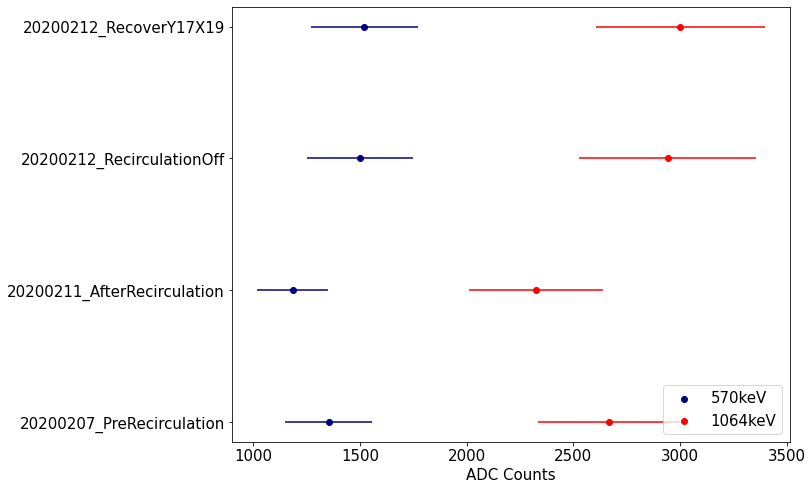

In [16]:
y_value = range(1,len(folder_list)+1)
plt.hlines(y=y_value, xmin=fit_parameters['position_first'] - fit_parameters['sigma_first'],\
           xmax=fit_parameters['position_first'] + fit_parameters['sigma_first'], color='navy')
plt.hlines(y=y_value, xmin=fit_parameters['position_second'] - fit_parameters['sigma_second'],\
           xmax=fit_parameters['position_second'] + fit_parameters['sigma_second'], color='red')
plt.scatter(fit_parameters['position_first'], y_value, color='navy', label='570keV')
plt.scatter(fit_parameters['position_second'], y_value, color='red', label='1064keV')
plt.yticks(y_value, folder_list)
plt.xlabel('ADC Counts')
plt.legend(loc='lower right')

in the next plot I'm looking at the position of the peaks in the different run the bars are the error of the mean

0    1352.939086
1    1184.283587
2    1500.488092
3    1520.525533
Name: position_first, dtype: float64
0    10.473709
1    22.112635
2    17.224263
3    15.346550
dtype: float64


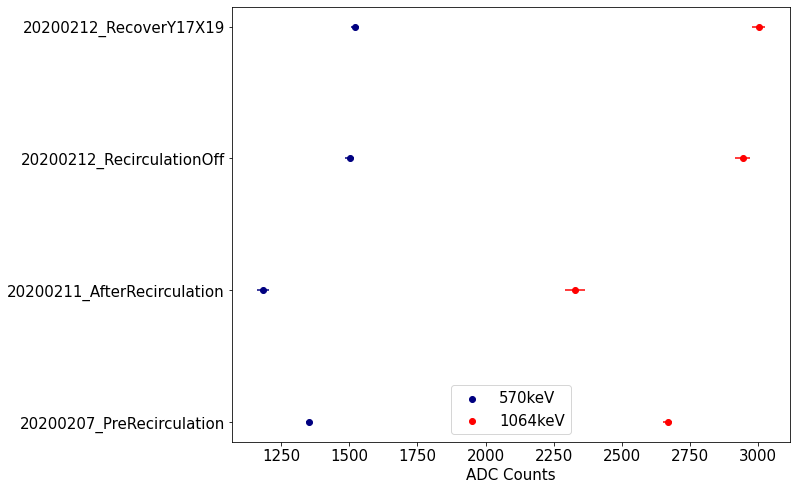

In [17]:
y_value = range(1,len(folder_list)+1)
error_first = np.hypot(np.sqrt(fit_parameters['sigma_first']/fit_parameters['ampl_first']),\
                       fit_parameters_error['position_first'])
error_second = np.hypot(np.sqrt(fit_parameters['sigma_second']/fit_parameters['ampl_second']),\
                       fit_parameters_error['position_second'])
plt.hlines(y=y_value, xmin=fit_parameters['position_first'] - error_first,\
           xmax=fit_parameters['position_first'] + error_first, color='navy')
plt.hlines(y=y_value, xmin=fit_parameters['position_second'] - error_second,\
           xmax=fit_parameters['position_second'] + error_second, color='red')
plt.scatter(fit_parameters['position_first'], y_value, color='navy', label='570keV')
plt.scatter(fit_parameters['position_second'], y_value, color='red', label='1064keV')
plt.yticks(y_value, folder_list)
plt.xlabel('ADC Counts')
plt.legend(loc='lower center')

Text(0.5, 0, 'Energy Resolution [%]')

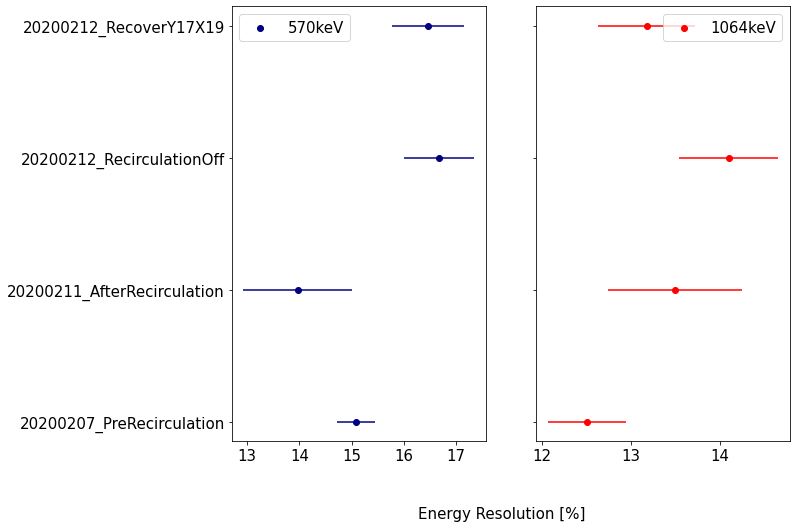

In [18]:
fig, ax = plt.subplots(1,2,sharey=True)
resolution_first  = fit_parameters['sigma_first']/fit_parameters['position_first']*100
resolution_second = fit_parameters['sigma_second']/fit_parameters['position_second']*100
resolution_first_error  = np.hypot(error_first/fit_parameters['position_first'],\
                                   fit_parameters_error['sigma_first']/fit_parameters['sigma_first'])*resolution_first
resolution_second_error = np.hypot(error_second/fit_parameters['position_second'],\
                                   fit_parameters_error['sigma_second']/fit_parameters['sigma_second'])*resolution_second
ax[0].hlines(y=y_value, xmin= resolution_first - resolution_first_error,\
           xmax= resolution_first + resolution_first_error, color='navy')
ax[1].hlines(y=y_value, xmin= resolution_second - resolution_second_error,\
           xmax= resolution_second + resolution_second_error, color='red')
ax[0].scatter(resolution_first, y_value, color='navy', label='570keV')
ax[1].scatter(resolution_second, y_value, color='red', label='1064keV')
plt.yticks(y_value, folder_list)
ax[0].legend()
ax[1].legend()
fig.text(0.5, 0,'Energy Resolution [%]', ha='center', va='center',fontsize=15)

here I calculate the ratio between the intensities of the two peaks of the source from the values obtained by the fit. The ratio from the branching ratios is 1.311. This approch, although not extremely robust as very dependent from the parameter of the fit, gives a rough idea on the whether the peaks are in the expected relative intensities

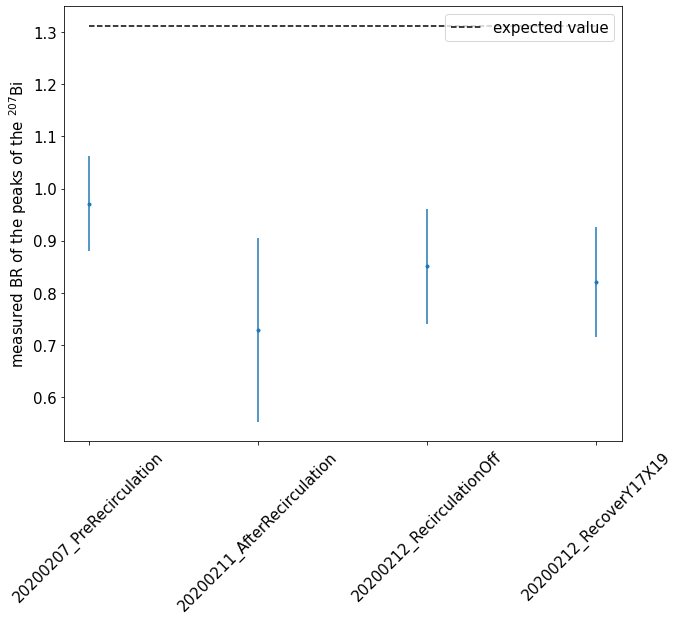

In [19]:
ampl_ratio = fit_parameters['ampl_first']*fit_parameters['sigma_first']/\
            (fit_parameters['ampl_second']*fit_parameters['sigma_second'])
ampl_ratio_error = (fit_parameters_error['ampl_first']/fit_parameters['ampl_first'] +\
                    fit_parameters_error['ampl_second']/fit_parameters['ampl_second'] +\
                   fit_parameters_error['sigma_first']/fit_parameters['sigma_first'] +\
                    fit_parameters_error['sigma_second']/fit_parameters['sigma_second'])*\
                    fit_parameters['ampl_first']/fit_parameters['ampl_second']
plt.errorbar(y_value,ampl_ratio,ampl_ratio_error,fmt='.')
plt.hlines(1.311, y_value[0], y_value[-1],linestyles='dashed',label='expected value')
plt.xticks(y_value, folder_list,rotation=45)
plt.ylabel('measured BR of the peaks of the $^{207}$Bi')
plt.legend()